In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
import sklearn.metrics as metrics
from sklearn.feature_selection import mutual_info_regression

from scipy.stats import boxcox, skew

import optuna
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostClassifier

import scipy.stats as stats

from sklego.linear_model import LADRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Импорт необходимых датасетов и их предобработка

In [2]:
data = pd.read_csv('ucdp-prio-acd-221.csv', encoding='windows-1251')
deaths = pd.read_csv('ucdp-brd-conf-221.csv')
external_debt_stocks = pd.read_csv('ext_debt_from_1985.csv')
inflation = pd.read_csv('inflation_from_1985.csv')
unemployment = pd.read_csv('unemployment.csv')
mortality = pd.read_csv('mortality.csv')
resources_rent_procent_of_GDP = pd.read_csv('resources_rent_%_of_GDP.csv')
military_expenditure = pd.read_csv('military_expenditure_%_of_GDP.csv')
arms_imports = pd.read_csv('arms_imports.csv')
democracy_full = pd.read_csv('V-Dem-CY-Full+Others-v13.csv', low_memory=False)
energy_access = pd.read_csv('share-of-the-population-with-access-to-electricity.csv')
trade = pd.read_csv('trade_openness.csv')

In [3]:
def delete_text_within_brackets(text):
    text = re.sub("\(.*?\)","()", text)
    return text

def delete_brackets(text):
    return text.replace('()', '').strip()

In [4]:
data.location = data.location.apply(delete_text_within_brackets)
data.location = data.location.apply(delete_brackets)

location_split = data.location.str.split(',')

In [5]:
location_split = pd.DataFrame(location_split)

location_split_by_country = location_split.location.apply(pd.Series)

In [6]:
location_split = pd.DataFrame(location_split)

location_split_by_country = location_split.location.apply(pd.Series)
location_split_by_country.columns = ['location', 'col1', 'col2', 'col3', 'col4', 'col5']

not_one_sided_conflicts = location_split_by_country.dropna(subset=location_split_by_country.columns[1:], how='all')

In [7]:
rows_to_remove = location_split_by_country[location_split_by_country.index.isin(not_one_sided_conflicts.index)].index

In [8]:
first_country = location_split_by_country.drop(index=rows_to_remove)

In [9]:
first_country = first_country.iloc[:, [0]]

In [10]:
data = data.drop(columns=['location'])

In [11]:
full_data = data.merge(first_country, how='inner', left_index=True, right_index=True)

In [12]:
full_data = full_data[['conflict_id', 'year', 'location', 'incompatibility', 'intensity_level', 'type_of_conflict']]

In [13]:
deaths = deaths.rename(columns={'location_inc': 'location'})

deaths.location = deaths.location.apply(delete_text_within_brackets).apply(delete_brackets)

location_split = deaths.location.str.split(',')
location_split = pd.DataFrame(location_split)

In [14]:
location_split_by_country = location_split.location.apply(pd.Series)
location_split_by_country.columns = ['location', 'col1', 'col2', 'col3']

not_one_sided_conflicts = location_split_by_country.dropna(subset=location_split_by_country.columns[1:], how='all')

rows_to_remove = location_split_by_country[location_split_by_country.index.isin(not_one_sided_conflicts.index)].index

first_country = location_split_by_country.drop(index=rows_to_remove)
first_country = first_country.iloc[:, [0]]

In [15]:
deaths = deaths.drop(columns=['location'])

In [16]:
full_deaths_data = deaths.merge(first_country, how='inner', left_index=True, right_index=True)

In [17]:
full_deaths_data = full_deaths_data[['conflict_id','location', 'year', 'bd_low']]

In [18]:
full_data_deaths_conflicts = full_data.merge(full_deaths_data, on=['conflict_id', 'year', 'location'], how='right')

In [19]:
full_data_deaths_conflicts = full_data_deaths_conflicts.rename(columns={'incompatibility': 'conflict_issue',
                                                                       'bd_low': 'battle_related_deaths'})

In [20]:
full_data_deaths_conflicts.location = full_data_deaths_conflicts.location.replace(['Congo', 'DR Congo', 'Egypt', 'Iran', 'Kyrgyzstan', 'Laos', 'Syria', 'Turkey', 'United States of America', 'Venezuela', 'Yemen', 'Bosnia-Herzegovina'],
                                               ['Congo, Rep.', 'Congo, Dem. Rep.', 'Egypt, Arab Rep.', 'Iran, Islamic Rep.', 'Kyrgyz Republic', 'Lao PDR', 'Syrian Arab Republic', 'Turkiye', 'United States', 'Venezuela, RB', 'Yemen, Rep.', 'Bosnia and Herzegovina'])

In [21]:
external_debt_stocks = external_debt_stocks[:217]

for name in external_debt_stocks.columns:
    if name[0].isdigit():
        external_debt_stocks = external_debt_stocks.rename(columns={f'{name}': name[:4]})
        
external_debt_stocks = external_debt_stocks.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

external_debt_stocks = external_debt_stocks.rename(columns={'Country Name': 'location'})

In [22]:
data = full_data_deaths_conflicts.merge(external_debt_stocks, on='location', how='left').dropna()

In [23]:
data.year = data.year.astype(str)

data.reset_index(inplace=True)

data = data.fillna(0)

In [24]:
ext_debt_stocks_list = []
for index, conflict_year in zip(data.index, data.year):
    if conflict_year in data.columns:
        ext_debt_stocks_list.append(data[f'{conflict_year}'].iloc[index])
    else:        
        ext_debt_stocks_list.append('0')
data['ext_debt_stocks'] = ext_debt_stocks_list      

data.ext_debt_stocks = pd.to_numeric(data.ext_debt_stocks, errors='coerce')

data.ext_debt_stocks = data.ext_debt_stocks.fillna(0)

In [25]:
data = data[['conflict_id', 'year', 'location', 'conflict_issue', 'intensity_level', 'type_of_conflict', 'battle_related_deaths', 'ext_debt_stocks']]

In [26]:
inflation = inflation[:217]

for name in inflation.columns:
    if name[0].isdigit():
        inflation = inflation.rename(columns={f'{name}': name[:4]})
        
inflation = inflation.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

inflation = inflation.rename(columns={'Country Name': 'location'})

for name in inflation.columns:
    if name[0].isdigit():
        inflation[f'{name}'] = pd.to_numeric(inflation[f'{name}'], errors='coerce')

In [27]:
inflation_list = []
for location, year in zip(data.location, data.year):
    if year in inflation.columns:
        inflation_list.append(inflation[f'{year}'].loc[inflation.location == location].item())
    else:
        inflation_list.append('0')
data['inflation_rate'] = inflation_list  

In [28]:
data.inflation_rate = data.inflation_rate.fillna(0)

data.inflation_rate = pd.to_numeric(data.inflation_rate)

In [29]:
data.ext_debt_stocks.loc[(data.location == 'South Sudan') & (data.ext_debt_stocks == 0)] = 208740000
data.ext_debt_stocks.loc[(data.location == 'Libya') & (data.ext_debt_stocks == 0)] = 4000000000
data.ext_debt_stocks.loc[(data.location == 'Israel') & (data.ext_debt_stocks == 0)] = 190000000
data.ext_debt_stocks.loc[(data.location == 'Azerbaijan') & (data.ext_debt_stocks == 0)] = 511485756
data.ext_debt_stocks.loc[(data.location == 'Croatia') & (data.ext_debt_stocks == 0)] = 2500000000
data.ext_debt_stocks.loc[(data.location == 'Georgia') & (data.ext_debt_stocks == 0)] = 80643087
data.ext_debt_stocks.loc[(data.location == 'Australia') & (data.ext_debt_stocks == 0)] = 533416000000
data.ext_debt_stocks.loc[(data.location == 'United States') & (data.ext_debt_stocks == 0)] = 100000000000

In [30]:
data.inflation_rate.loc[(data.location == 'Syrian Arab Republic') & (data.inflation_rate == 0)] = 200
data.inflation_rate.loc[(data.location == 'Uzbekistan') & (data.inflation_rate == 0)] = 29.1
data.inflation_rate.loc[(data.location == 'Eritrea') & (data.inflation_rate == 0)] = 9
data.inflation_rate.loc[(data.location == 'Yemen, Rep.') & (data.inflation_rate == 0)] = 22
data.inflation_rate.loc[(data.location == 'Congo, Dem. Rep.') & (data.inflation_rate == 0)] = 4.71
data.inflation_rate.loc[(data.location == 'Somalia') & (data.inflation_rate == 0)] = 3.7
data.inflation_rate.loc[(data.location == 'Guinea') & (data.inflation_rate == 0)] = 8.64
data.inflation_rate.loc[(data.location == 'Iraq') & (data.inflation_rate == 0)] = 180.95
data.inflation_rate.loc[(data.location == 'Libya') & (data.inflation_rate == 0)] = 10
data.inflation_rate.loc[(data.location == 'Djibouti') & (data.inflation_rate == 0)] = 6.8
data.inflation_rate.loc[(data.location == 'Georgia') & (data.inflation_rate == 0)] = 62.2
data.inflation_rate.loc[(data.location == 'Sierra Leone') & (data.inflation_rate == 0)] = 102.69
data.inflation_rate.loc[(data.location == 'Azerbaijan') & (data.inflation_rate == 0)] = 83.5
data.inflation_rate.loc[(data.location == 'Tajikistan') & (data.inflation_rate == 0)] = 574
data.inflation_rate.loc[(data.location == 'Lesotho') & (data.inflation_rate == 0)] = 7.5

In [31]:
unemployment = unemployment[:217]

for name in unemployment.columns:
    if name[0].isdigit():
        unemployment = unemployment.rename(columns={f'{name}': name[:4]})
        
unemployment = unemployment.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

unemployment = unemployment.rename(columns={'Country Name': 'location'})

for name in unemployment.columns:
    if name[0].isdigit():
        unemployment[f'{name}'] = pd.to_numeric(unemployment[f'{name}'], errors='coerce')
        
unemployment = unemployment.fillna(0)

In [32]:
unemployment_list = []
for location, year in zip(data.location, data.year):
    if year in unemployment.columns:
        unemployment_list.append(unemployment[f'{year}'].loc[unemployment.location == location].item())
    else:
        unemployment_list.append('0')
data['unemployment_rate'] = unemployment_list  

In [33]:
data.unemployment_rate.loc[(data.location == 'Burkina Faso') & (data.unemployment_rate == 0)] = 4.69
data.unemployment_rate.loc[(data.location == 'South Sudan') & (data.unemployment_rate == 0)] = 12.2
data.unemployment_rate.loc[(data.location == 'Libya') & (data.unemployment_rate == 0)] = 19.39
data.unemployment_rate.loc[(data.location == 'Mali') & (data.unemployment_rate == 0)] = 9.29
data.unemployment_rate.loc[(data.location == 'Pakistan') & (data.unemployment_rate == 0)] = 3.78
data.unemployment_rate.loc[(data.location == 'Myanmar') & (data.unemployment_rate == 0)] = 0.76
data.unemployment_rate.loc[(data.location == 'Syrian Arab Republic') & (data.unemployment_rate == 0) & (data.year == '2013')] = 8.83
data.unemployment_rate.loc[(data.location == 'Syrian Arab Republic') & (data.unemployment_rate == 0) & (data.year == '2012')] = 8.81
data.unemployment_rate.loc[(data.location == 'Syrian Arab Republic') & (data.unemployment_rate == 0) & (data.year == '2016')] = 8.73
data.unemployment_rate.loc[(data.location == 'Mozambique') & (data.unemployment_rate == 0)] = 3.47
data.unemployment_rate.loc[(data.location == 'Afghanistan') & (data.unemployment_rate == 0) & (data.year == '2015')] = 11.3
data.unemployment_rate.loc[(data.location == 'Ethiopia') & (data.unemployment_rate == 0) & (data.year == '2019')] = 2.33
data.unemployment_rate.loc[(data.location == 'Guinea') & (data.unemployment_rate == 0)] = 4.55
data.unemployment_rate.loc[(data.location == 'Chad') & (data.unemployment_rate == 0)] = 1.07
data.unemployment_rate.loc[(data.location == 'Eritrea') & (data.unemployment_rate == 0)] = 6.08
data.unemployment_rate.loc[(data.location == 'Yemen, Rep.') & (data.unemployment_rate == 0)] = 13.77
data.unemployment_rate.loc[(data.location == 'Kenya') & (data.unemployment_rate == 0)] = 2.78
data.unemployment_rate.loc[(data.location == 'India') & (data.unemployment_rate == 0)] = 5.44
data.unemployment_rate.loc[(data.location == 'Congo, Dem. Rep.') & (data.unemployment_rate == 0) & (data.year == '2019')] = 4.45
data.unemployment_rate.loc[(data.location == 'Congo, Dem. Rep.') & (data.unemployment_rate == 0) & (data.year == '2007')] = 3.31
data.unemployment_rate.loc[(data.location == 'Lebanon') & (data.unemployment_rate == 0)] = 8.81
data.unemployment_rate.loc[(data.location == 'Uzbekistan') & (data.unemployment_rate == 0)] = 13.3
data.unemployment_rate.loc[(data.location == 'Guinea-Bissau') & (data.unemployment_rate == 0)] = 6.35
data.unemployment_rate.loc[(data.location == 'Central African Republic') & (data.unemployment_rate == 0) & (data.year == '2001')] = 5.69
data.unemployment_rate.loc[(data.location == 'Central African Republic') & (data.unemployment_rate == 0) & (data.year == '2015')] = 5.61
data.unemployment_rate.loc[(data.location == 'Congo, Rep.') & (data.unemployment_rate == 0)] = 20.7
data.unemployment_rate.loc[(data.location == 'Bosnia and Herzegovina') & (data.unemployment_rate == 0)] = 18.3
data.unemployment_rate.loc[(data.location == 'Rwanda') & (data.unemployment_rate == 0)] = 0.3
data.unemployment_rate.loc[(data.location == 'Somalia') & (data.unemployment_rate == 0)] = 18.85
data.unemployment_rate.loc[(data.location == 'Iraq') & (data.unemployment_rate == 0)] = 9.1
data.unemployment_rate.loc[(data.location == 'Senegal') & (data.unemployment_rate == 0)] = 5.5
data.unemployment_rate.loc[(data.location == 'Djibouti') & (data.unemployment_rate == 0)] = 29.36
data.unemployment_rate.loc[(data.location == 'Angola') & (data.unemployment_rate == 0)] = 4.21
data.unemployment_rate.loc[(data.location == 'Sierra Leone') & (data.unemployment_rate == 0)] = 3.47
data.unemployment_rate.loc[(data.location == 'Serbia') & (data.unemployment_rate == 0)] = 13.33
data.unemployment_rate.loc[(data.location == 'Croatia') & (data.unemployment_rate == 0)] = 11.01
data.unemployment_rate.loc[(data.location == 'Moldova') & (data.unemployment_rate == 0)] = 3.7
data.unemployment_rate.loc[(data.location == 'Comoros') & (data.unemployment_rate == 0)] = 4.83
data.unemployment_rate.loc[(data.location == 'Mauritania') & (data.unemployment_rate == 0)] = 9.86
data.unemployment_rate.loc[(data.location == 'Afghanistan') & (data.unemployment_rate == 0)] = 11.05
data.unemployment_rate.loc[(data.location == 'Ethiopia') & (data.unemployment_rate == 0)] = 3.08
data.unemployment_rate.loc[(data.location == 'Lesotho') & (data.unemployment_rate == 0)] = 37.16

In [34]:
mortality = mortality[:217]

for name in mortality.columns:
    if name[0].isdigit():
        mortality = mortality.rename(columns={f'{name}': name[:4]})
        
mortality = mortality.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

mortality = mortality.rename(columns={'Country Name': 'location'})

for name in mortality.columns:
    if name[0].isdigit():
        mortality[f'{name}'] = pd.to_numeric(mortality[f'{name}'], errors='coerce')
        
mortality = mortality.fillna(0)

In [35]:
mortality_list = []
for location, year in zip(data.location, data.year):
    if year in mortality.columns:
        mortality_list.append(mortality[f'{year}'].loc[mortality.location == location].item())
    else:
        mortality_list.append('0')
data['mortality_by_1000'] = mortality_list  

In [36]:
data.mortality_by_1000.loc[(data.location == 'Kyrgyz Republic') & (data.mortality_by_1000 == 0)] = 6

In [37]:
resources_rent_procent_of_GDP = resources_rent_procent_of_GDP[:217]

for name in resources_rent_procent_of_GDP.columns:
    if name[0].isdigit():
        resources_rent_procent_of_GDP = resources_rent_procent_of_GDP.rename(columns={f'{name}': name[:4]})
        
resources_rent_procent_of_GDP = resources_rent_procent_of_GDP.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

resources_rent_procent_of_GDP = resources_rent_procent_of_GDP.rename(columns={'Country Name': 'location'})

for name in resources_rent_procent_of_GDP.columns:
    if name[0].isdigit():
        resources_rent_procent_of_GDP[f'{name}'] = pd.to_numeric(resources_rent_procent_of_GDP[f'{name}'], errors='coerce')
        
resources_rent_procent_of_GDP = resources_rent_procent_of_GDP.fillna(0)

In [38]:
resources_rent_procent_of_GDP_list = []
for location, year in zip(data.location, data.year):
    if year in resources_rent_procent_of_GDP.columns:
        resources_rent_procent_of_GDP_list.append(resources_rent_procent_of_GDP[f'{year}'].loc[resources_rent_procent_of_GDP.location == location].item())
    else:
        resources_rent_procent_of_GDP_list.append('0')
data['resources_rent_procent_of_GDP'] = resources_rent_procent_of_GDP_list  

In [39]:
data.resources_rent_procent_of_GDP.loc[(data.location == 'Angola') & (data.resources_rent_procent_of_GDP == 0)] = 28.9
data.resources_rent_procent_of_GDP.loc[(data.location == 'Azerbaijan') & (data.resources_rent_procent_of_GDP == 0)] = 38.2
data.resources_rent_procent_of_GDP.loc[(data.location == 'Georgia') & (data.resources_rent_procent_of_GDP == 0)] = 0.3
data.resources_rent_procent_of_GDP.loc[(data.location == 'Serbia') & (data.resources_rent_procent_of_GDP == 0)] = 0.5
data.resources_rent_procent_of_GDP.loc[(data.location == 'Bosnia and Herzegovina') & (data.resources_rent_procent_of_GDP == 0)] = 0.2
data.resources_rent_procent_of_GDP.loc[(data.location == 'Croatia') & (data.resources_rent_procent_of_GDP == 0)] = 0.7
data.resources_rent_procent_of_GDP.loc[(data.location == 'Moldova') & (data.resources_rent_procent_of_GDP == 0)] = 0.25
data.resources_rent_procent_of_GDP.loc[(data.location == 'Kyrgyz Republic') & (data.resources_rent_procent_of_GDP == 0)] = 12
data.resources_rent_procent_of_GDP.loc[(data.location == 'Afghanistan') & (data.resources_rent_procent_of_GDP == 0)] = 1.2

In [40]:
military_expenditure = military_expenditure[:217]

for name in military_expenditure.columns:
    if name[0].isdigit():
        military_expenditure = military_expenditure.rename(columns={f'{name}': name[:4]})
        
military_expenditure = military_expenditure.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

military_expenditure = military_expenditure.rename(columns={'Country Name': 'location'})

for name in military_expenditure.columns:
    if name[0].isdigit():
        military_expenditure[f'{name}'] = pd.to_numeric(military_expenditure[f'{name}'], errors='coerce')
        
military_expenditure = military_expenditure.fillna(0)

In [41]:
military_expenditure_list = []
for location, year in zip(data.location, data.year):
    if year in military_expenditure.columns:
        military_expenditure_list.append(military_expenditure[f'{year}'].loc[military_expenditure.location == location].item())
    else:
        military_expenditure_list.append('0')
data['military_expenditure_procent_of_GDP'] = military_expenditure_list  

In [42]:
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Sudan') & (data.military_expenditure_procent_of_GDP == 0)] = 5.45
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Libya') & (data.military_expenditure_procent_of_GDP == 0)] = 7.26
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Syrian Arab Republic') & (data.military_expenditure_procent_of_GDP == 0)] = 4.1
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Niger') & (data.military_expenditure_procent_of_GDP == 0)] = 1.6
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Yemen, Rep.') & (data.military_expenditure_procent_of_GDP == 0)] = 3.9
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Somalia') & (data.military_expenditure_procent_of_GDP == 0)] = 1.2
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Myanmar') & (data.military_expenditure_procent_of_GDP == 0)] = 13.5
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Azerbaijan') & (data.military_expenditure_procent_of_GDP == 0)] = 0.011
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Central African Republic') & (data.military_expenditure_procent_of_GDP == 0)] = 1.0
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Georgia') & (data.military_expenditure_procent_of_GDP == 0)] = 1.1
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Serbia') & (data.military_expenditure_procent_of_GDP == 0)] = 5.4
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Mauritania') & (data.military_expenditure_procent_of_GDP == 0)] = 2.3
data.military_expenditure_procent_of_GDP.loc[(data.location == 'Afghanistan') & (data.military_expenditure_procent_of_GDP == 0)] = 2.5

In [43]:
arms_imports = arms_imports[:217]

for name in arms_imports.columns:
    if name[0].isdigit():
        arms_imports = arms_imports.rename(columns={f'{name}': name[:4]})
        
arms_imports = arms_imports.drop(['Series Name', 'Series Code', 'Country Code'], axis=1)

arms_imports = arms_imports.rename(columns={'Country Name': 'location'})

for name in arms_imports.columns:
    if name[0].isdigit():
        arms_imports[f'{name}'] = pd.to_numeric(arms_imports[f'{name}'], errors='coerce')
        
arms_imports = arms_imports.fillna(0)

In [44]:
arms_imports_list = []
for location, year in zip(data.location, data.year):
    if year in arms_imports.columns:
        arms_imports_list.append(arms_imports[f'{year}'].loc[arms_imports.location == location].item())
    else:
        arms_imports_list.append('0')
data['arms_imports'] = arms_imports_list  

In [45]:
data.arms_imports.loc[(data.location == 'Angola') & (data.arms_imports == 0)] = 50000000

In [46]:
data.arms_imports.loc[(data.location == 'Libya') & (data.arms_imports == 0)] = 116000000

In [47]:
democracy_full = democracy_full[(democracy_full.year > 1984) & (democracy_full.year < 2022)]

In [48]:
democracy_lib = democracy_full[['country_name', 'year', 'v2x_libdem']]

democracy_lib = democracy_lib.rename(columns={'country_name': 'location', 'v2x_libdem': 'democracy_index'})

data.year = data.year.astype(int)

data = pd.merge(data, democracy_lib, on=['year', 'location'] , how='left')

In [49]:
data.democracy_index = data.democracy_index.fillna(0)

In [50]:
data.democracy_index.loc[(data.location == 'Turkiye') & (data.democracy_index == 0) & (data.year == 2015)] = 0.6
data.democracy_index.loc[(data.location == 'Turkiye') & (data.democracy_index == 0) & (data.year == 1991)] = 0.4
data.democracy_index.loc[(data.location == 'Myanmar') & (data.democracy_index == 0) & (data.year == 1991)] = 0.1
data.democracy_index.loc[(data.location == 'Myanmar') & (data.democracy_index == 0) & (data.year == 2009)] = 0.1
data.democracy_index.loc[(data.location == 'Myanmar') & (data.democracy_index == 0) & (data.year == 1997)] = 0.1
data.democracy_index.loc[(data.location == 'Syrian Arab Republic') & (data.democracy_index == 0) & (data.year == 2012)] = 0.15
data.democracy_index.loc[(data.location == 'Syrian Arab Republic') & (data.democracy_index == 0) & (data.year == 2013)] = 0.14
data.democracy_index.loc[(data.location == 'Syrian Arab Republic') & (data.democracy_index == 0) & (data.year == 2016)] = 0.14
data.democracy_index.loc[(data.location == 'Iran, Islamic Rep.') & (data.democracy_index == 0) & (data.year == 2018)] = 0.2
data.democracy_index.loc[(data.location == 'Iran, Islamic Rep.') & (data.democracy_index == 0) & (data.year == 2017)] = 0.2
data.democracy_index.loc[(data.location == 'Yemen, Rep.') & (data.democracy_index == 0) & (data.year == 2015)] = 0.18
data.democracy_index.loc[(data.location == 'Yemen, Rep.') & (data.democracy_index == 0) & (data.year == 1994)] = 0.32
data.democracy_index.loc[(data.location == 'Egypt, Arab Rep.') & (data.democracy_index == 0) & (data.year == 2015)] = 0.17
data.democracy_index.loc[(data.location == 'Egypt, Arab Rep.') & (data.democracy_index == 0) & (data.year == 1993)] = 0.21
data.democracy_index.loc[(data.location == 'Congo, Dem. Rep.') & (data.democracy_index == 0) & (data.year == 2019)] = 0.35
data.democracy_index.loc[(data.location == 'Congo, Dem. Rep.') & (data.democracy_index == 0) & (data.year == 2007)] = 0.36
data.democracy_index.loc[(data.location == 'Congo, Rep.') &  (data.democracy_index == 0) & (data.year == 2019)] = 0.24
data.democracy_index.loc[(data.location == 'Congo, Rep.') & (data.democracy_index == 0) & (data.year == 1993)] = 0.47
data.democracy_index.loc[(data.location == 'United States') & (data.democracy_index == 0)] = 0.83
data.democracy_index.loc[(data.location == 'Kyrgyz Republic') & (data.democracy_index == 0)] = 0.29

In [51]:
democracy_corruption = democracy_full[['year', 'country_name', 'v2x_corr']]

democracy_corruption = democracy_corruption.rename(columns={'country_name': 'location', 'v2x_corr': 'corruption_index'})

data = pd.merge(data, democracy_corruption, on=['year', 'location'], how='left')

data.corruption_index = data.corruption_index.fillna(0)

In [52]:
data.corruption_index.loc[(data.location == 'Kyrgyz Republic') & (data.corruption_index == 0) & (data.year == 2021)] = 0.73
data.corruption_index.loc[(data.location == 'Turkiye') & (data.corruption_index == 0) & (data.year == 2015)] = 0.58
data.corruption_index.loc[(data.location == 'Myanmar') & (data.corruption_index == 0) & (data.year == 2009)] = 0.85
data.corruption_index.loc[(data.location == 'Myanmar') & (data.corruption_index == 0) & (data.year == 1991)] = 0.8
data.corruption_index.loc[(data.location == 'Syrian Arab Republic') & (data.corruption_index == 0) & (data.year == 2012)] = 0.8
data.corruption_index.loc[(data.location == 'Syrian Arab Republic') & (data.corruption_index == 0) & (data.year == 2016)] = 0.87
data.corruption_index.loc[(data.location == 'Iran, Islamic Rep.') & (data.corruption_index == 0) & (data.year == 2018)] = 0.72
data.corruption_index.loc[(data.location == 'Iran, Islamic Rep.') & (data.corruption_index == 0) & (data.year == 2017)] = 0.7
data.corruption_index.loc[(data.location == 'Yemen, Rep.') & (data.corruption_index == 0) & (data.year == 2015)] = 0.82
data.corruption_index.loc[(data.location == 'Egypt, Arab Rep.') & (data.corruption_index == 0) & (data.year == 2015)] = 0.64
data.corruption_index.loc[(data.location == 'Egypt, Arab Rep.') & (data.corruption_index == 0) & (data.year == 1993)] = 0.68
data.corruption_index.loc[(data.location == 'Congo, Dem. Rep.') & (data.corruption_index == 0) & (data.year == 2019)] = 0.82
data.corruption_index.loc[(data.location == 'Congo, Dem. Rep.') & (data.corruption_index == 0) & (data.year == 2007)] = 0.73
data.corruption_index.loc[(data.location == 'United States') & (data.corruption_index == 0)] = 0.12

In [53]:
GPD_per_capita = democracy_full[['year', 'country_name', 'e_gdp']]

GPD_per_capita = GPD_per_capita.rename(columns={'country_name': 'location', 'e_gdp': 'GPD_per_capita'})

data = pd.merge(data, GPD_per_capita, on=['year', 'location'], how='left')

data.GPD_per_capita = data.GPD_per_capita.fillna(0)

In [54]:
data.GPD_per_capita.loc[(data.location == 'Kyrgyz Republic') & (data.GPD_per_capita == 0) & (data.year == 2021)] = 1276
data.GPD_per_capita.loc[(data.location == 'Turkiye') & (data.GPD_per_capita == 0) & (data.year == 2015)] = 25959
data.GPD_per_capita.loc[(data.location == 'Turkiye') & (data.GPD_per_capita == 0) & (data.year == 1991)] = 12507
data.GPD_per_capita.loc[(data.location == 'Myanmar') & (data.GPD_per_capita == 0) & (data.year == 1991)] = 563
data.GPD_per_capita.loc[(data.location == 'Myanmar') & (data.GPD_per_capita == 0) & (data.year == 2009)] = 2527
data.GPD_per_capita.loc[(data.location == 'Myanmar') & (data.GPD_per_capita == 0) & (data.year == 1997)] = 763
data.GPD_per_capita.loc[(data.location == 'Syrian Arab Republic') & (data.GPD_per_capita == 0) & (data.year == 2012)] = 2158
data.GPD_per_capita.loc[(data.location == 'Syrian Arab Republic') & (data.GPD_per_capita == 0) & (data.year == 2016)] = 713
data.GPD_per_capita.loc[(data.location == 'Syrian Arab Republic') & (data.GPD_per_capita == 0) & (data.year == 2013)] = 1151
data.GPD_per_capita.loc[(data.location == 'Iran, Islamic Rep.') & (data.GPD_per_capita == 0) & (data.year == 2018)] = 13472
data.GPD_per_capita.loc[(data.location == 'Iran, Islamic Rep.') & (data.GPD_per_capita == 0) & (data.year == 2017)] = 14536
data.GPD_per_capita.loc[(data.location == 'Yemen, Rep.') & (data.GPD_per_capita == 0) & (data.year == 2015)] = 1601
data.GPD_per_capita.loc[(data.location == 'Yemen, Rep.') & (data.GPD_per_capita == 0) & (data.year == 1994)] = 291
data.GPD_per_capita.loc[(data.location == 'Egypt, Arab Rep.') & (data.GPD_per_capita == 0) & (data.year == 2015)] = 3563
data.GPD_per_capita.loc[(data.location == 'Egypt, Arab Rep.') & (data.GPD_per_capita == 0) & (data.year == 1993)] = 6203
data.GPD_per_capita.loc[(data.location == 'Congo, Dem. Rep.') & (data.GPD_per_capita == 0) & (data.year == 2019)] = 1098
data.GPD_per_capita.loc[(data.location == 'Congo, Dem. Rep.') & (data.GPD_per_capita == 0) & (data.year == 2007)] = 817
data.GPD_per_capita.loc[(data.location == 'Congo, Rep.') & (data.GPD_per_capita == 0) & (data.year == 1993)] = 1151
data.GPD_per_capita.loc[(data.location == 'United States') & (data.GPD_per_capita == 0)] = 50127
data.GPD_per_capita.loc[(data.location == 'Tanzania') & (data.GPD_per_capita == 0)] = 2635

In [55]:
fertility = democracy_full[['year', 'country_name', 'e_miferrat']]

fertility = fertility.rename(columns={'country_name': 'location', 'e_miferrat': 'fertility_rate'})

data = pd.merge(data, fertility, on=['year', 'location'], how='left')

data.fertility_rate = data.fertility_rate.fillna(0)

In [56]:
data.fertility_rate.loc[(data.location == 'Serbia') & (data.fertility_rate == 0) & (data.year == 1993)] = 1.8
data.fertility_rate.loc[(data.location == 'Turkiye') & (data.fertility_rate == 0) & (data.year == 2015)] = 2.1
data.fertility_rate.loc[(data.location == 'Turkiye') & (data.fertility_rate == 0) & (data.year == 1991)] = 3.0
data.fertility_rate.loc[(data.location == 'Myanmar') & (data.fertility_rate == 0) & (data.year == 1991)] = 3.3
data.fertility_rate.loc[(data.location == 'Syrian Arab Republic') & (data.fertility_rate == 0) & (data.year == 2012)] = 3.1
data.fertility_rate.loc[(data.location == 'Syrian Arab Republic') & (data.fertility_rate == 0) & (data.year == 2013)] = 3.0
data.fertility_rate.loc[(data.location == 'Syrian Arab Republic') & (data.fertility_rate == 0) & (data.year == 2016)] = 2.9
data.fertility_rate.loc[(data.location == 'Iran, Islamic Rep.') & (data.fertility_rate == 0) & (data.year == 2018)] = 1.6
data.fertility_rate.loc[(data.location == 'Iran, Islamic Rep.') & (data.fertility_rate == 0) & (data.year == 2017)] = 1.6
data.fertility_rate.loc[(data.location == 'Yemen, Rep.') & (data.fertility_rate == 0) & (data.year == 2015)] = 4.1
data.fertility_rate.loc[(data.location == 'Egypt, Arab Rep.') & (data.fertility_rate == 0) & (data.year == 2015)] = 3.3
data.fertility_rate.loc[(data.location == 'Egypt, Arab Rep.') & (data.fertility_rate == 0) & (data.year == 1993)] = 4.1
data.fertility_rate.loc[(data.location == 'Congo, Dem. Rep.') & (data.fertility_rate == 0) & (data.year == 2019)] = 5.8
data.fertility_rate.loc[(data.location == 'Congo, Dem. Rep.') & (data.fertility_rate == 0) & (data.year == 2007)] = 6.6
data.fertility_rate.loc[(data.location == 'Congo, Rep.') & (data.fertility_rate == 0) & (data.year == 1993)] = 5.2
data.fertility_rate.loc[(data.location == 'United States') & (data.fertility_rate == 0) & (data.year == 2001)] = 2.0
data.fertility_rate.loc[(data.location == 'Myanmar') & (data.fertility_rate == 0) & (data.year == 2009)] = 2.5
data.fertility_rate.loc[(data.location == 'Myanmar') & (data.fertility_rate == 0) & (data.year == 1997)] = 3.0
data.fertility_rate.loc[(data.location == 'Tanzania') & (data.fertility_rate == 0) & (data.year == 2020)] = 4.8
data.fertility_rate.loc[(data.location == 'Yemen, Rep.') & (data.fertility_rate == 0) & (data.year == 1994)] = 7.8
data.fertility_rate.loc[(data.location == 'Kyrgyz Republic') & (data.fertility_rate == 0) & (data.year == 2021)] = 2.9

In [57]:
energy_access = energy_access.rename(columns={'Entity': 'location', 'Year': 'year',
                                              'Access to electricity (% of population)': 'energy_access_procent_of_population'})

energy_access = energy_access[['year', 'location', 'energy_access_procent_of_population']]

In [58]:
data = pd.merge(data, energy_access, on=['year', 'location'], how='left')

In [59]:
data.energy_access_procent_of_population = data.energy_access_procent_of_population.fillna(0)

In [60]:
data.energy_access_procent_of_population.loc[(data.location == 'Turkiye') & (data.energy_access_procent_of_population == 0) & (data.year == 2015)] = 100
data.energy_access_procent_of_population.loc[(data.location == 'Myanmar') & (data.energy_access_procent_of_population == 0) & (data.year == 1991)] = 35
data.energy_access_procent_of_population.loc[(data.location == 'Syrian Arab Republic') & (data.energy_access_procent_of_population == 0) & (data.year == 2012)] = 90.8
data.energy_access_procent_of_population.loc[(data.location == 'Syrian Arab Republic') & (data.energy_access_procent_of_population == 0) & (data.year == 2013)] = 90.2
data.energy_access_procent_of_population.loc[(data.location == 'Syrian Arab Republic') & (data.energy_access_procent_of_population == 0) & (data.year == 2016)] = 89.7
data.energy_access_procent_of_population.loc[(data.location == 'Iran, Islamic Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2018)] = 100
data.energy_access_procent_of_population.loc[(data.location == 'Yemen, Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2015)] = 67.3
data.energy_access_procent_of_population.loc[(data.location == 'Egypt, Arab Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2015)] = 99.3
data.energy_access_procent_of_population.loc[(data.location == 'Congo, Dem. Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2019)] = 19.1
data.energy_access_procent_of_population.loc[(data.location == 'Congo, Dem. Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2007)] = 15.2
data.energy_access_procent_of_population.loc[(data.location == 'Niger') & (data.energy_access_procent_of_population == 0) & (data.year == 1991)] = 4.2
data.energy_access_procent_of_population.loc[(data.location == 'India') & (data.energy_access_procent_of_population == 0) & (data.year == 1989)] = 39
data.energy_access_procent_of_population.loc[(data.location == 'India') & (data.energy_access_procent_of_population == 0) & (data.year == 1990)] = 41
data.energy_access_procent_of_population.loc[(data.location == 'Burkina Faso') & (data.energy_access_procent_of_population == 0) & (data.year == 1987)] = 2.5
data.energy_access_procent_of_population.loc[(data.location == 'Congo, Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 1993)] = 11.3
data.energy_access_procent_of_population.loc[(data.location == 'Yemen, Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 1994)] = 42
data.energy_access_procent_of_population.loc[(data.location == 'Indonesia') & (data.energy_access_procent_of_population == 0) & (data.year == 1990)] = 48
data.energy_access_procent_of_population.loc[(data.location == 'Rwanda') & (data.energy_access_procent_of_population == 0) & (data.year == 1990)] = 0.7
data.energy_access_procent_of_population.loc[(data.location == 'Mali') & (data.energy_access_procent_of_population == 0) & (data.year == 1990)] = 0.3
data.energy_access_procent_of_population.loc[(data.location == 'Iran, Islamic Rep.') & (data.energy_access_procent_of_population == 0) & (data.year == 2017)] = 99.9


In [61]:
population = democracy_full[['year', 'country_name', 'e_pop']]

population = population.rename(columns={'country_name': 'location', 'e_pop': 'population'})

data = pd.merge(data, population, on=['year', 'location'], how='left')

data.population = data.population.fillna(0)

In [62]:
data.population.loc[(data.location == 'Kyrgyz Republic') & (data.population == 0) & (data.year == 2021)] = 632
data.population.loc[(data.location == 'Turkiye') & (data.population == 0) & (data.year == 2015)] = 7965
data.population.loc[(data.location == 'Turkiye') & (data.population == 0) & (data.year == 1991)] = 5532
data.population.loc[(data.location == 'Myanmar') & (data.population == 0) & (data.year == 1991)] = 4068
data.population.loc[(data.location == 'Myanmar') & (data.population == 0) & (data.year == 2009)] = 4902
data.population.loc[(data.location == 'Myanmar') & (data.population == 0) & (data.year == 1997)] = 4397
data.population.loc[(data.location == 'Syrian Arab Republic') & (data.population == 0) & (data.year == 2012)] = 2261
data.population.loc[(data.location == 'Syrian Arab Republic') & (data.population == 0) & (data.year == 2013)] = 2150
data.population.loc[(data.location == 'Syrian Arab Republic') & (data.population == 0) & (data.year == 2016)] = 1896
data.population.loc[(data.location == 'Iran, Islamic Rep.') & (data.population == 0) & (data.year == 2018)] = 8562
data.population.loc[(data.location == 'Yemen, Rep.') & (data.population == 0) & (data.year == 2015)] = 2852
data.population.loc[(data.location == 'Egypt, Arab Rep.') & (data.population == 0) & (data.year == 2015)] = 9752
data.population.loc[(data.location == 'Egypt, Arab Rep.') & (data.population == 0) & (data.year == 1993)] = 6138
data.population.loc[(data.location == 'Congo, Dem. Rep.') & (data.population == 0) & (data.year == 2019)] = 8991
data.population.loc[(data.location == 'Congo, Dem. Rep.') & (data.population == 0) & (data.year == 2007)] = 6029
data.population.loc[(data.location == 'Congo, Rep.') & (data.population == 0) & (data.year == 1993)] = 259
data.population.loc[(data.location == 'United States') & (data.population == 0)] = 28547
data.population.loc[(data.location == 'Yemen, Rep.') & (data.population == 0) & (data.year == 1994)] = 1555
data.population.loc[(data.location == 'Tanzania') & (data.population == 0) & (data.year == 2020)] = 6170
data.population.loc[(data.location == 'Iran, Islamic Rep.') & (data.population == 0) & (data.year == 2017)] = 8451

In [63]:
unseat_current_state_head = democracy_full[['year', 'country_name', 'e_pt_coup']]

unseat_current_state_head = unseat_current_state_head.rename(columns={'country_name': 'location', 
                                                                      'e_pt_coup': 'unseat_current_state_head_attempt'})

data = pd.merge(data, unseat_current_state_head, on=['year', 'location'], how='left')

In [64]:
data.unseat_current_state_head_attempt = data.unseat_current_state_head_attempt.fillna(0)

In [65]:
trade = trade.drop(columns=['Code']).rename(columns={'Entity': 'location',
                                                     'Trade openness (share of exports and imports in GDP)': 'trade_openness',
                                                     'Year': 'year'})        
trade = trade.fillna(0)

data = pd.merge(data, trade, on=['year', 'location'], how='left')

In [66]:
data.trade_openness = data.trade_openness.fillna(0)

In [67]:
data.trade_openness = np.where(data.trade_openness > 100, 100, data.trade_openness / 10)

In [68]:
data.trade_openness.loc[(data.location == 'Afghanistan') & (data.trade_openness == 0) & (data.year == 2001)] = 5.8
data.trade_openness.loc[(data.location == 'Niger') & (data.trade_openness == 0) & (data.year == 1994)] = 3.3
data.trade_openness.loc[(data.location == 'Trinidad and Tobago') & (data.trade_openness == 0) & (data.year == 1990)] = 5
data.trade_openness.loc[(data.location == 'Cameroon') & (data.trade_openness == 0) & (data.year == 1996)] = 4.8
data.trade_openness.loc[(data.location == 'Niger') & (data.trade_openness == 0) & (data.year == 1995)] = 3.4
data.trade_openness.loc[(data.location == 'Moldova') & (data.trade_openness == 0) & (data.year == 1992)] = 6.9
data.trade_openness.loc[(data.location == 'Comoros') & (data.trade_openness == 0) & (data.year == 1997)] = 6.1
data.trade_openness.loc[(data.location == 'North Macedonia') & (data.trade_openness == 0) & (data.year == 2001)] = 7.1
data.trade_openness.loc[(data.location == 'Azerbaijan') & (data.trade_openness == 0) & (data.year == 1993)] = 10
data.trade_openness.loc[(data.location == 'Mexico') & (data.trade_openness == 0) & (data.year == 1994)] = 3.1
data.trade_openness.loc[(data.location == 'Yemen, Rep.') & (data.trade_openness == 0) & (data.year == 1994)] = 4.1
data.trade_openness.loc[(data.location == 'Pakistan') & (data.trade_openness == 0) & (data.year == 1990)] = 2.6
data.trade_openness.loc[(data.location == 'Georgia') & (data.trade_openness == 0) & (data.year == 1992)] = 10
data.trade_openness.loc[(data.location == 'Bosnia and Herzegovina') & (data.trade_openness == 0)] = 9.7
data.trade_openness.loc[(data.location == 'Tajikistan') & (data.trade_openness == 0) & (data.year == 1992)] = 10
data.trade_openness.loc[(data.location == 'Croatia') & (data.trade_openness == 0) & (data.year == 1992)] = 8.1
data.trade_openness.loc[(data.location == 'Iraq') & (data.trade_openness == 0) & (data.year == 1990)] = 10
data.trade_openness.loc[(data.location == 'Senegal') & (data.trade_openness == 0) & (data.year == 1990)] = 3.6
data.trade_openness.loc[(data.location == 'Libya') & (data.trade_openness == 0) & (data.year == 2015)] = 10
data.trade_openness.loc[(data.location == 'Libya') & (data.trade_openness == 0) & (data.year == 2015)] = 10
data.trade_openness.loc[(data.location == 'Djibouti') & (data.trade_openness == 0) & (data.year == 1991)] = 3.0
data.trade_openness.loc[(data.location == 'Algeria') & (data.trade_openness == 0) & (data.year == 1991)] = 5.2
data.trade_openness.loc[(data.location == 'Algeria') & (data.trade_openness == 0) & (data.year == 1991)] = 5.2
data.trade_openness.loc[(data.location == 'Angola') & (data.trade_openness == 0) & (data.year == 1991)] = 5
data.trade_openness.loc[(data.location == 'Georgia') & (data.trade_openness == 0) & (data.year == 1991)] = 5.9
data.trade_openness.loc[(data.location == 'Haiti') & (data.trade_openness == 0) & (data.year == 1989)] = 4
data.trade_openness.loc[(data.location == 'Sierra Leone') & (data.trade_openness == 0) & (data.year == 1991)] = 4.2
data.trade_openness.loc[(data.location == 'Egypt, Arab Rep.') & (data.trade_openness == 0) & (data.year == 1993)] = 5.6
data.trade_openness.loc[(data.location == 'Serbia') & (data.trade_openness == 0) & (data.year == 1991)] = 2.3
data.trade_openness.loc[(data.location == 'Azerbaijan') & (data.trade_openness == 0) & (data.year == 1991)] = 8.7
data.trade_openness.loc[(data.location == 'Congo, Rep.') & (data.trade_openness == 0) & (data.year == 1993)] = 9.1
data.trade_openness.loc[(data.location == 'Guinea-Bissau') & (data.trade_openness == 0) & (data.year == 1998)] = 2.7
data.trade_openness.loc[(data.location == 'Comoros') & (data.trade_openness == 0) & (data.year == 1989)] = 5.8
data.trade_openness.loc[(data.location == 'Panama') & (data.trade_openness == 0) & (data.year == 1989)] = 10
data.trade_openness.loc[(data.location == 'Romania') & (data.trade_openness == 0) & (data.year == 1989)] = 3.5
data.trade_openness.loc[(data.location == 'Papua New Guinea') & (data.trade_openness == 0) & (data.year == 1990)] = 4.3
data.trade_openness.loc[(data.location == 'Ecuador') & (data.trade_openness == 0) & (data.year == 1995)] = 4.4
data.trade_openness.loc[(data.location == 'Nigeria') & (data.trade_openness == 0) & (data.year == 2004)] = 3.1
data.trade_openness.loc[(data.location == 'Iran, Islamic Rep.') & (data.trade_openness == 0) & (data.year == 2017)] =4.9
data.trade_openness.loc[(data.location == 'Tunisia') & (data.trade_openness == 0) & (data.year == 2016)] = 9.1
data.trade_openness.loc[(data.location == 'Thailand') & (data.trade_openness == 0) & (data.year == 2003)] = 10
data.trade_openness.loc[(data.location == 'United States') & (data.trade_openness == 0)] = 2.2
data.trade_openness.loc[(data.location == 'Australia') & (data.trade_openness == 0) & (data.year == 2003)] = 3.7
data.trade_openness.loc[(data.location == 'Myanmar') & (data.trade_openness == 0) & (data.year == 1997)] = 5.2
data.trade_openness.loc[(data.location == 'Uzbekistan') & (data.trade_openness == 0) & (data.year == 1999)] = 3.5
data.trade_openness.loc[(data.location == 'Eritrea') & (data.trade_openness == 0) & (data.year == 1998)] = 8.7
data.trade_openness.loc[(data.location == 'Central African Republic') & (data.trade_openness == 0) & (data.year == 2001)] = 4.2
data.trade_openness.loc[(data.location == 'Ukraine') & (data.trade_openness == 0) & (data.year == 2014)] = 10
data.trade_openness.loc[(data.location == 'Lesotho') & (data.trade_openness == 0) & (data.year == 1998)] = 10
data.trade_openness.loc[(data.location == 'Serbia') & (data.trade_openness == 0) & (data.year == 1998)] = 4.2
data.trade_openness.loc[(data.location == 'Jordan') & (data.trade_openness == 0) & (data.year == 2016)] = 8.8
data.trade_openness.loc[(data.location == 'Turkiye') & (data.trade_openness == 0) & (data.year == 2015)] = 5.1
data.trade_openness.loc[(data.location == 'South Sudan') & (data.trade_openness == 0) & (data.year == 2011)] = 10
data.trade_openness.loc[(data.location == 'Libya') & (data.trade_openness == 0) & (data.year == 2011)] = 10
data.trade_openness.loc[(data.location == 'China') & (data.trade_openness == 0) & (data.year == 2008)] = 5.7
data.trade_openness.loc[(data.location == 'Ethiopia') & (data.trade_openness == 0) & (data.year == 1991)] = 1.3
data.trade_openness.loc[(data.location == 'Myanmar') & (data.trade_openness == 0) & (data.year == 1991)] = 0.3
data.trade_openness.loc[(data.location == 'Myanmar') & (data.trade_openness == 0) & (data.year == 2009)] = 3.4
data.trade_openness.loc[(data.location == 'Syrian Arab Republic') & (data.trade_openness == 0) & (data.year == 2012)] = 6.3
data.trade_openness.loc[(data.location == 'Syrian Arab Republic') & (data.trade_openness == 0) & (data.year == 2013)] = 6.5
data.trade_openness.loc[(data.location == 'Syrian Arab Republic') & (data.trade_openness == 0) & (data.year == 2016)] = 6.4
data.trade_openness.loc[(data.location == 'Philippines') & (data.trade_openness == 0) & (data.year == 2016)] = 6.5
data.trade_openness.loc[(data.location == 'Iran, Islamic Rep.') & (data.trade_openness == 0) & (data.year == 2018)] = 4.2
data.trade_openness.loc[(data.location == 'Israel') & (data.trade_openness == 0) & (data.year == 1990)] = 6.4
data.trade_openness.loc[(data.location == 'Niger') & (data.trade_openness == 0) & (data.year == 1991)] = 3.0
data.trade_openness.loc[(data.location == 'Guinea') & (data.trade_openness == 0) & (data.year == 2000)] = 3.1
data.trade_openness.loc[(data.location == 'Somalia') & (data.trade_openness == 0) & (data.year == 2018)] = 0.01
data.trade_openness.loc[(data.location == 'Malaysia') & (data.trade_openness == 0) & (data.year == 2013)] = 10
data.trade_openness.loc[(data.location == 'Eritrea') & (data.trade_openness == 0) & (data.year == 1997)] = 10
data.trade_openness.loc[(data.location == 'Egypt, Arab Rep.') & (data.trade_openness == 0) & (data.year == 2015)] = 3.5
data.trade_openness.loc[(data.location == 'India') & (data.trade_openness == 0) & (data.year == 2015)] = 4.2
data.trade_openness.loc[(data.location == 'India') & (data.trade_openness == 0) & (data.year == 1990)] = 0.15
data.trade_openness.loc[(data.location == 'India') & (data.trade_openness == 0) & (data.year == 1989)] = 0.15
data.trade_openness.loc[(data.location == 'Mali') & (data.trade_openness == 0) & (data.year == 1990)] = 0.4
data.trade_openness.loc[(data.location == 'Indonesia') & (data.trade_openness == 0) & (data.year == 1990)] = 0.45
data.trade_openness.loc[(data.location == 'Rwanda') & (data.trade_openness == 0) & (data.year == 1990)] = 0.2
data.trade_openness.loc[(data.location == 'Burkina Faso') & (data.trade_openness == 0) & (data.year == 1987)] = 3.9
data.trade_openness.loc[(data.location == 'Lebanon') & (data.trade_openness == 0) & (data.year == 2014)] = 7.9
data.trade_openness.loc[(data.location == 'India') & (data.trade_openness == 0) & (data.year == 2012)] = 5.5
data.trade_openness.loc[(data.location == 'Burkina Faso') & (data.trade_openness == 0) & (data.year == 2019)] = 5.6
data.trade_openness.loc[(data.location == 'Mali') & (data.trade_openness == 0) & (data.year == 2009)] = 5.1
data.trade_openness.loc[(data.location == 'Sudan') & (data.trade_openness == 0) & (data.year == 2011)] = 3.1
data.trade_openness.loc[(data.location == 'Mozambique') & (data.trade_openness == 0) & (data.year == 2019)] = 10
data.trade_openness.loc[(data.location == 'Congo, Dem. Rep.') & (data.trade_openness == 0) & (data.year == 2007)] = 8
data.trade_openness.loc[(data.location == 'Ethiopia') & (data.trade_openness == 0) & (data.year == 2019)] = 4.5
data.trade_openness.loc[(data.location == 'Pakistan') & (data.trade_openness == 0) & (data.year == 2016)] = 2.5
data.trade_openness.loc[(data.location == 'Bangladesh') & (data.trade_openness == 0) & (data.year == 2005)] = 3.8
data.trade_openness.loc[(data.location == 'Mali') & (data.trade_openness == 0) & (data.year == 2017)] = 5.8
data.trade_openness.loc[(data.location == 'Cameroon') & (data.trade_openness == 0) & (data.year == 2017)] = 4.2
data.trade_openness.loc[(data.location == 'Afghanistan') & (data.trade_openness == 0) & (data.year == 2015)] = 4.9
data.trade_openness.loc[(data.location == 'Cameroon') & (data.trade_openness == 0) & (data.year == 2015)] = 4.9
data.trade_openness.loc[(data.location == 'Chad') & (data.trade_openness == 0) & (data.year == 2015)] = 5.2
data.trade_openness.loc[(data.location == 'Niger') & (data.trade_openness == 0) & (data.year == 2015)] = 4.5
data.trade_openness.loc[(data.location == 'Nigeria') & (data.trade_openness == 0) & (data.year == 2015)] = 2.1
data.trade_openness.loc[(data.location == 'Yemen, Rep.') & (data.trade_openness == 0) & (data.year == 2015)] = 3.6
data.trade_openness.loc[(data.location == 'Kenya') & (data.trade_openness == 0) & (data.year == 2015)] = 4.4
data.trade_openness.loc[(data.location == 'Turkiye') & (data.trade_openness == 0) & (data.year == 1991)] = 2.4
data.trade_openness.loc[(data.location == 'Somalia') & (data.trade_openness == 0) & (data.year == 2019)] = 0.02
data.trade_openness.loc[(data.location == 'Congo, Dem. Rep.') & (data.trade_openness == 0) & (data.year == 2019)] = 6.7
data.trade_openness.loc[(data.location == 'Bangladesh') & (data.trade_openness == 0) & (data.year == 2016)] = 3.8
data.trade_openness.loc[(data.location == 'South Sudan') & (data.trade_openness == 0) & (data.year == 2012)] = 7.3
data.trade_openness.loc[(data.location == 'Mali') & (data.trade_openness == 0) & (data.year == 2015)] = 6.4
data.trade_openness.loc[(data.location == 'Central African Republic	') & (data.trade_openness == 0) & (data.year == 2015)] = 5.3

In [69]:
state_control_over_territory = democracy_full[['year', 'country_name', 'v2svstterr']]

state_control_over_territory = state_control_over_territory.rename(columns={'country_name': 'location', 'v2svstterr': 'state_control_over_territory'})

data = pd.merge(data, state_control_over_territory, on=['year', 'location'], how='left')

data.state_control_over_territory = data.state_control_over_territory.fillna(0)

In [70]:
political_violence = democracy_full[['year', 'country_name', 'v2caviol']]

political_violence = political_violence.rename(columns={'country_name': 'location', 'v2caviol': 'political_violence'})

data = pd.merge(data, political_violence, on=['year', 'location'], how='left')

data.political_violence = data.political_violence.fillna(0)

In [71]:
data = data[data['GPD_per_capita'] != 0]

In [72]:
data = data.drop(data[data.location == 'United States'].index)

In [73]:
missed_values = data.drop(columns=['conflict_id', 'year', 'location', 
                                   'battle_related_deaths', 'conflict_issue',
                                  'intensity_level', 'type_of_conflict',
                                  'unseat_current_state_head_attempt', 'arms_imports']).apply(lambda x: (x==0).sum())

In [74]:
missed_values = pd.DataFrame(missed_values, columns=['count'])

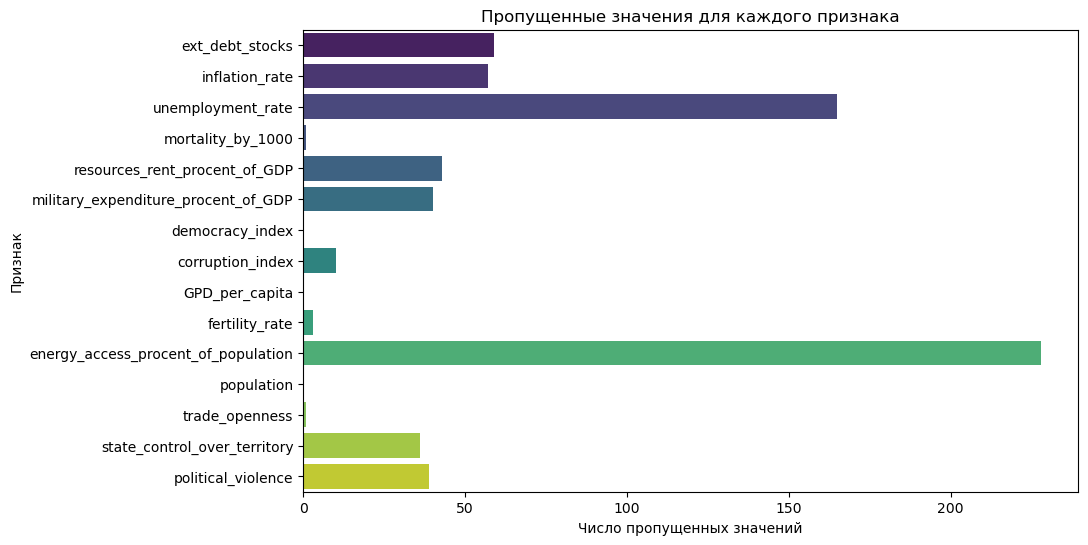

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y=missed_values.index, data=missed_values, palette='viridis')
plt.title('Пропущенные значения для каждого признака')
plt.xlabel('Число пропущенных значений')
plt.ylabel('Признак')
plt.show()

#unseat_current_state_head_attempt and arms_imports - бинарные признаки и поэтому не учитываются в таблице

In [77]:
def features_initial_rescaling(data):
    data = data.copy()
    
    data.GPD_per_capita = np.log(data.GPD_per_capita)

    data.arms_imports = data.arms_imports.replace(0, 1)

    data.arms_imports = np.log(data.arms_imports)

    data.political_violence = (data.political_violence)**2
    data.political_violence = (data.political_violence)**(0.5)
    
    return data

In [78]:
data = features_initial_rescaling(data)

In [79]:
data['is_conflict'] = data.battle_related_deaths.apply(lambda x: 1 if x > 25 else 0)

# EDA и построение модели

In [80]:
data = data.drop(columns=['conflict_issue', 'intensity_level', 'type_of_conflict',
                         'conflict_id', 'year', 'location', 'battle_related_deaths'])

In [81]:
numeric_columns = data.copy().drop(columns=['unseat_current_state_head_attempt', 'is_conflict']).columns

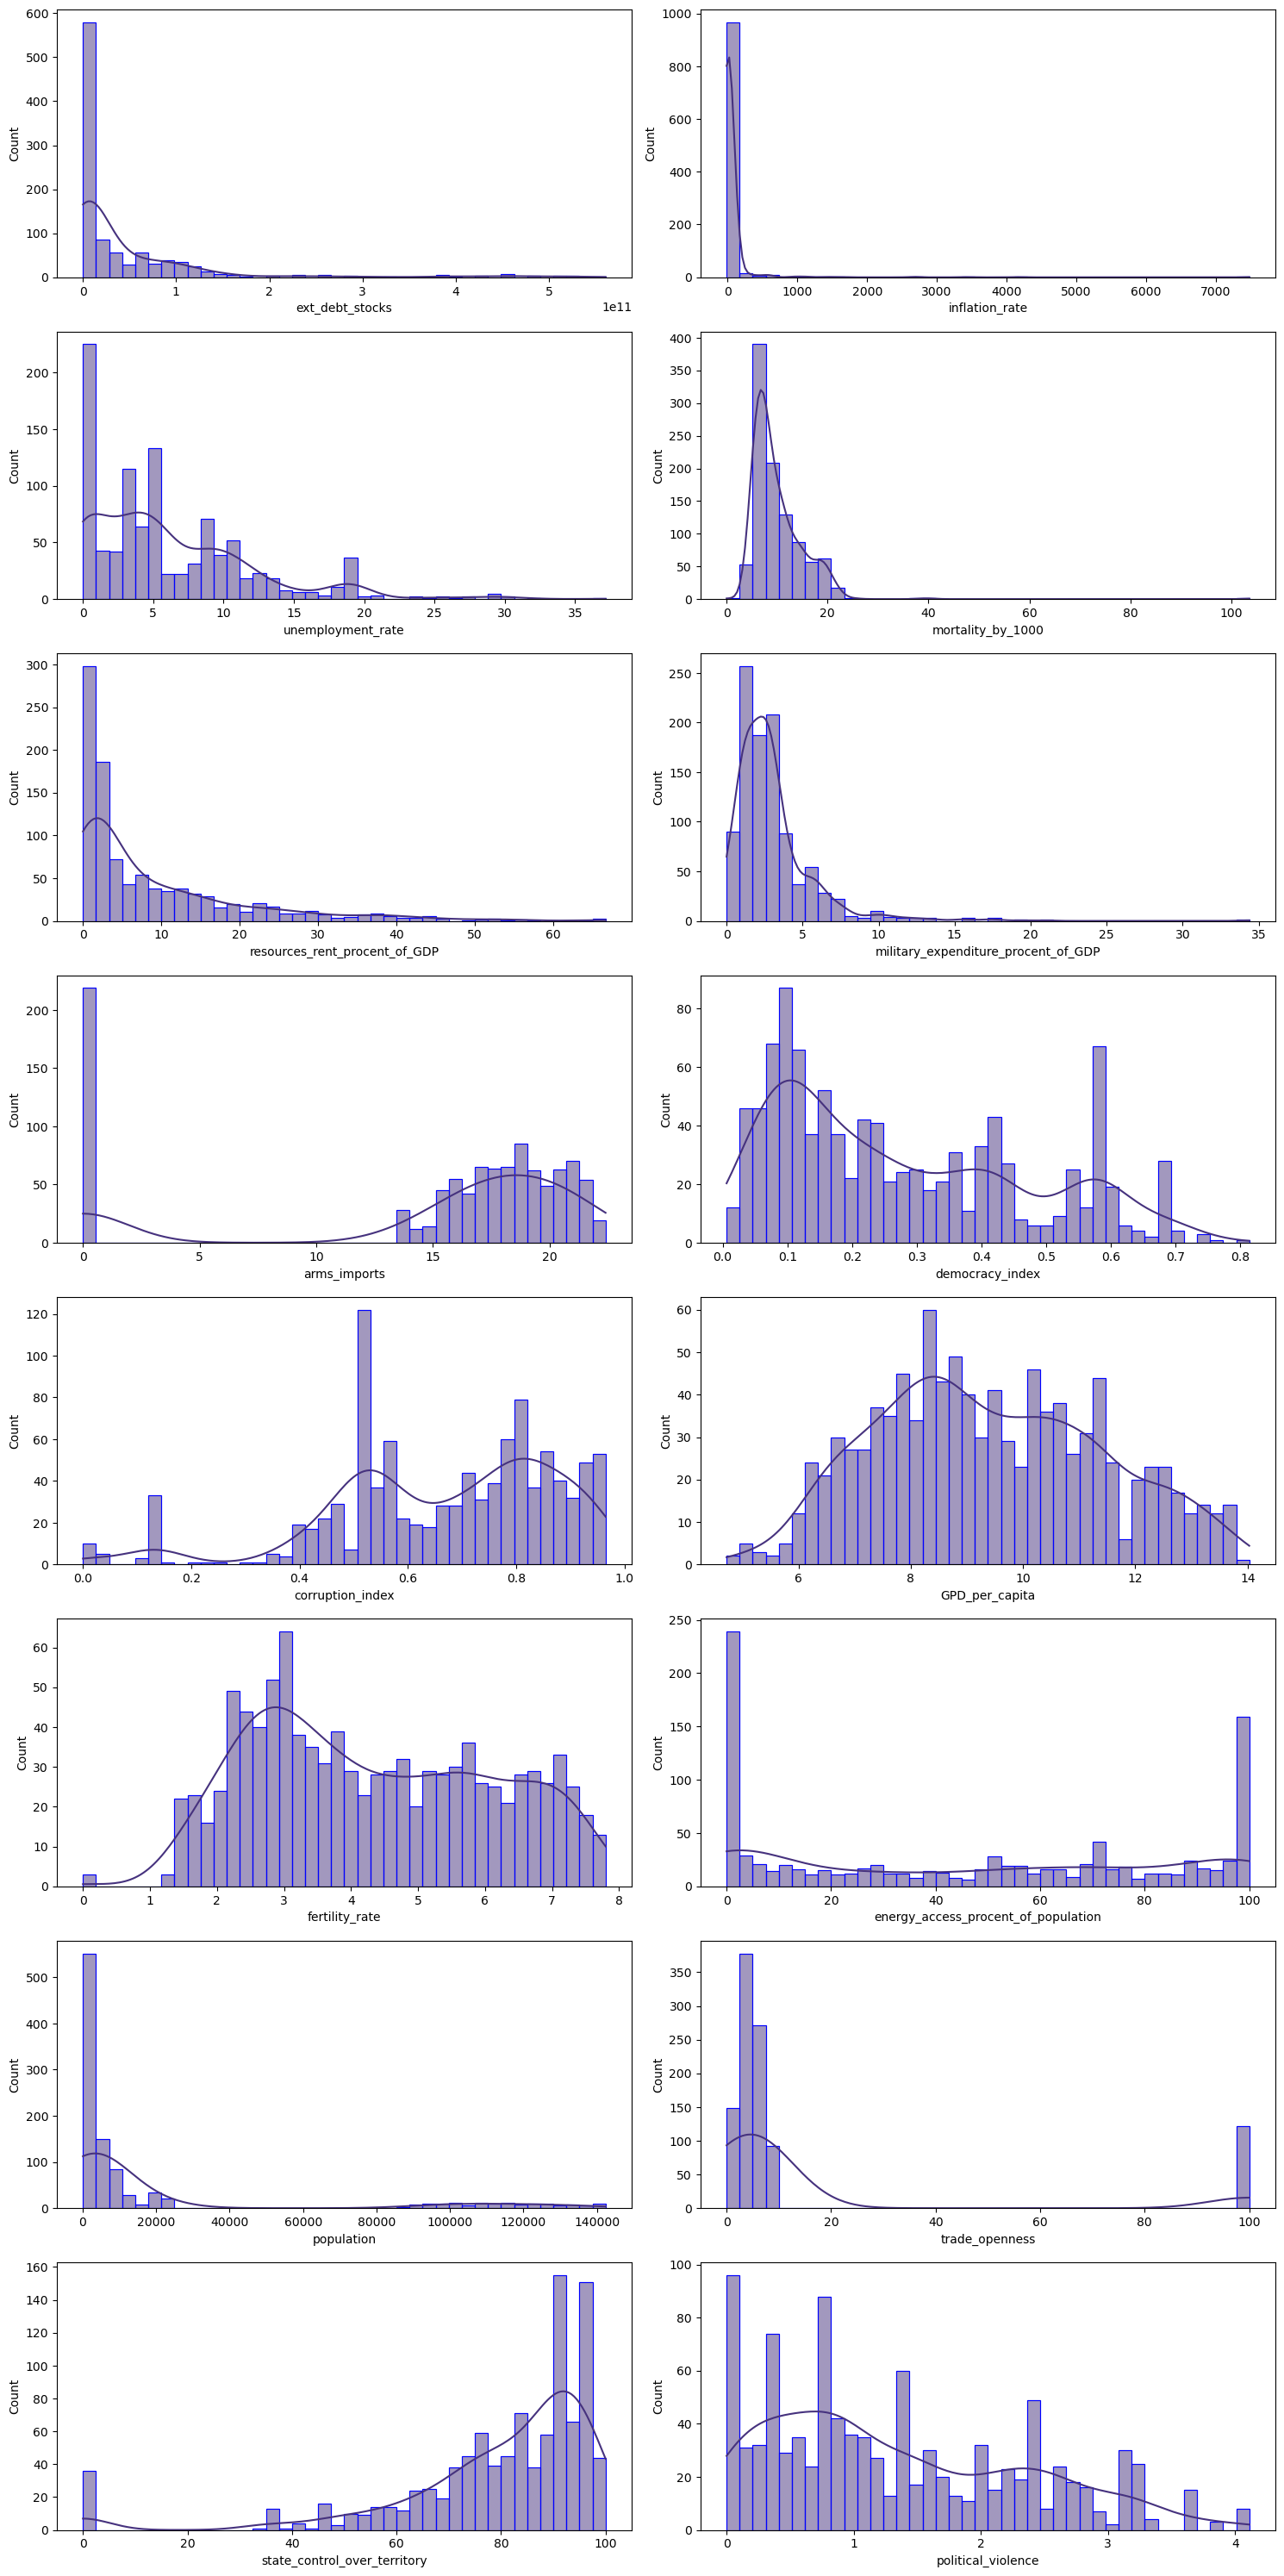

In [82]:
#графики распределения числовых переменных
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))  

for i, feature in enumerate(numeric_columns):
    row = i // 2  
    col = i % 2   
    
    sns.histplot(data=data, x=feature, kde=True, bins=40, edgecolor='blue', color=sns.color_palette("viridis")[0],
                 multiple='stack', ax=axes[row, col])

plt.tight_layout()
plt.show()

Ни одна переменная, за исключением ВВП на душу населения (GPD_per_capita), чье распределение близко к нормальному, такового не имеет. Для имеющихся переменных попробуем уменьшить ассиметричность распределения, сделав его более близким к нормальному

In [83]:
skewness_values = data.copy().drop(columns=['unseat_current_state_head_attempt', 
                                            'is_conflict']).apply(lambda x: x.skew()).reset_index(name='Skewness')
skewness_df = pd.DataFrame({'Variable': skewness_values['index'], 'Skewness': skewness_values['Skewness']})

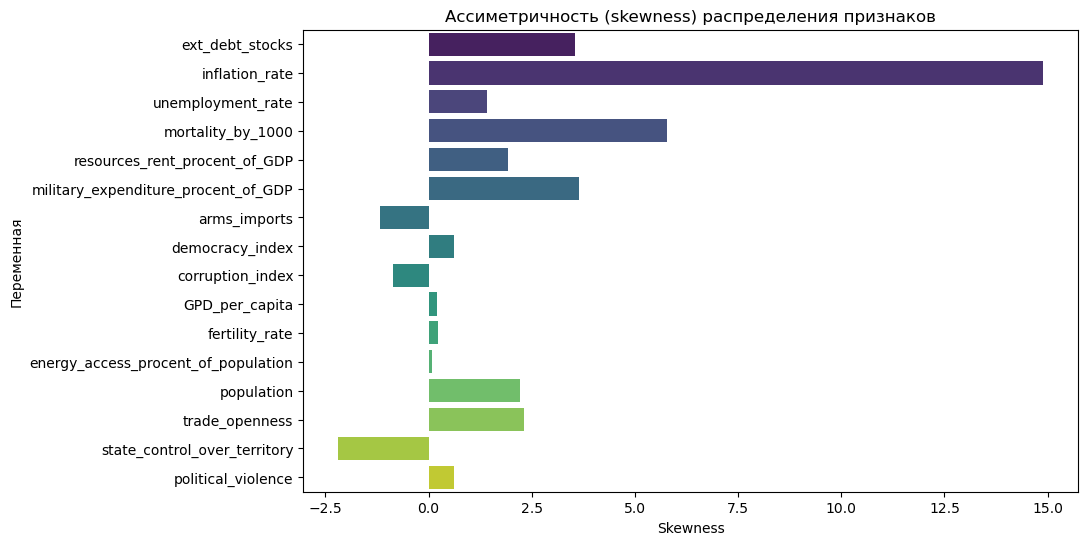

In [84]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Skewness', y='Variable', data=skewness_df, palette='viridis')
plt.title('Ассиметричность (skewness) распределения признаков')
plt.xlabel('Skewness')
plt.ylabel('Переменная')
plt.show()

In [85]:
def decrease_skewness(data, target_feature, cat_features=[], skew_threshold=0.75):
    transformed_df = data.copy()
    transformed_columns = []
    
    for col in transformed_df.columns:
        if (col != target_feature) & (col not in cat_features):
            skewness = skew(transformed_df[col])
            
            if skewness > skew_threshold: # график распределения смещен вправо
                transformed_columns.append(f'{col}')
                transformed_df[col] = np.log1p(transformed_df[col])
            
            elif skewness < (-skew_threshold): # график распределения смещен вправо
                transformed_columns.append(f'{col}')
                transformed_df[col] = transformed_df[col] ** 2
    
    return transformed_df, transformed_columns

In [86]:
data, high_skew_columns = decrease_skewness(data, 'is_conflict', ['unseat_current_state_head_attempt'], 0.75)

C:\Users\user\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [87]:
high_skew_columns

['ext_debt_stocks',
 'inflation_rate',
 'unemployment_rate',
 'mortality_by_1000',
 'resources_rent_procent_of_GDP',
 'military_expenditure_procent_of_GDP',
 'arms_imports',
 'corruption_index',
 'population',
 'trade_openness',
 'state_control_over_territory']

In [88]:
data = data.fillna(0)

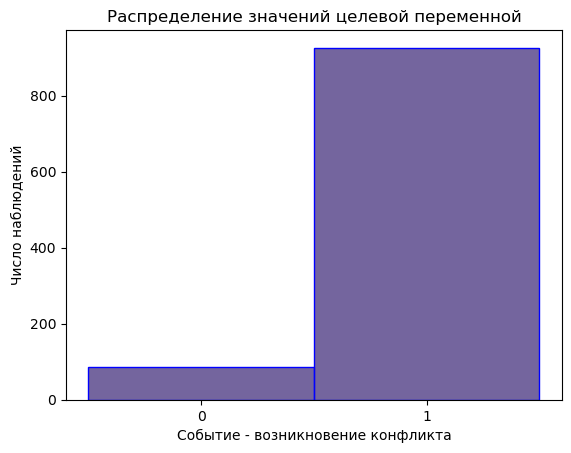

In [89]:
sns.histplot(data.is_conflict, bins=[-0.5, 0.5, 1.5], edgecolor='blue', color=sns.color_palette("viridis")[0])
plt.xticks([0, 1])
plt.xlabel('Событие - возникновение конфликта')
plt.ylabel('Число наблюдений')
plt.title('Распределение значений целевой переменной')
plt.show()

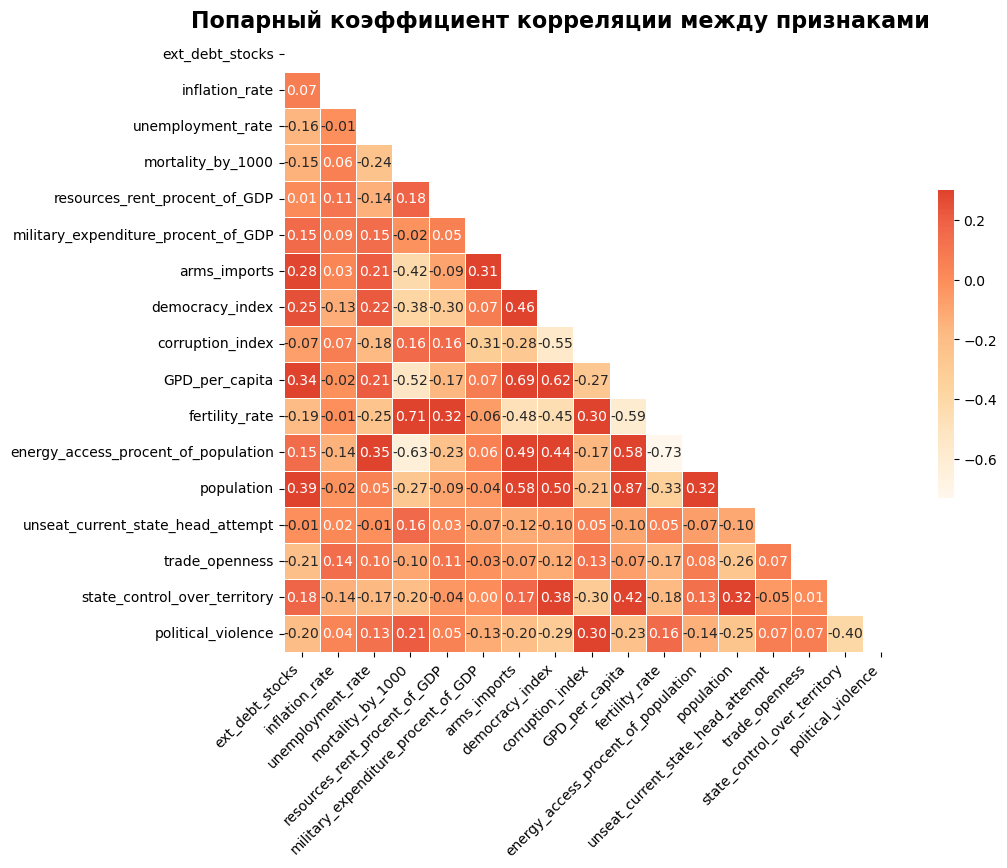

In [90]:
corr = data.copy().drop(columns=['is_conflict']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='OrRd', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Попарный коэффициент корреляции между признаками", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

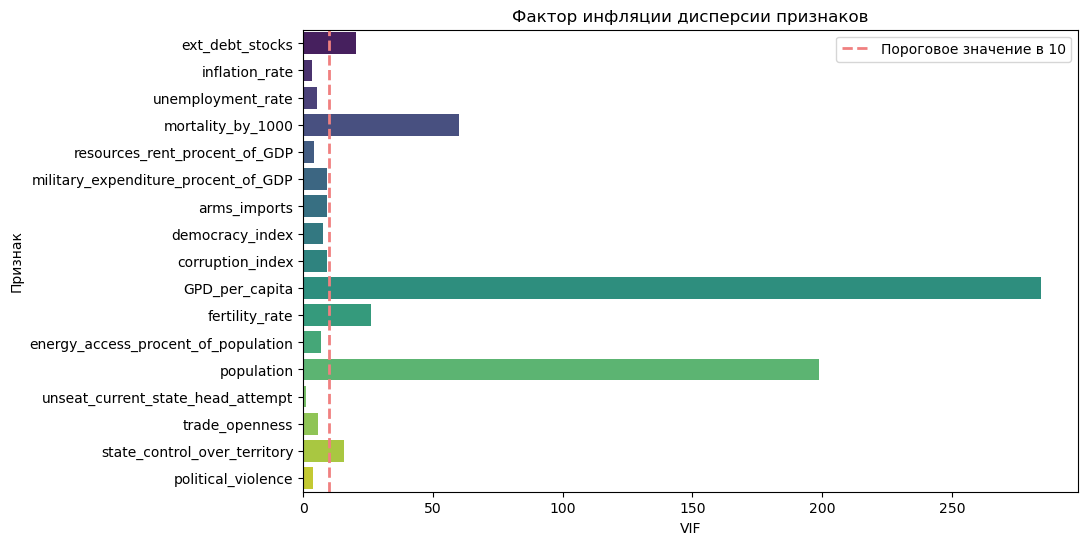

In [91]:
vif_data = pd.DataFrame()
vif_data["feature"] = data.copy().drop(columns=['is_conflict']).columns
vif_data["VIF"] = [variance_inflation_factor(data.copy().drop(columns=['is_conflict']).values, i)
                          for i in range(len(data.copy().drop(columns=['is_conflict']).columns))]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis')
ax.axvline(x=10, color='lightcoral', linestyle='--', linewidth=2, label='Пороговое значение в 10')
plt.title('Фактор инфляции дисперсии признаков')
plt.xlabel('VIF')
plt.ylabel('Признак')
ax.legend()
plt.show()

По шкале Чеддока пороговым значением коэффициента корреляции между двумя переменными, при котором они линейно зависимы - 0.75  
Видим одно высокое значение в 0.87 между признаками Население (population) и ВВП на душу населения (GPD_per_capita).  
Откинем признак GPD_per_capita, учитывая, что его фактор инфляции дисперсии выше.  
Очень близким к пороговому значению находится коэффициент корреляции между детской смертностью (fertility_rate) и смертностью на 1000 человек населения (mortality_by_1000). Откинем первый признак.

In [93]:
data = data.drop(columns=['GPD_per_capita', 'fertility_rate'])

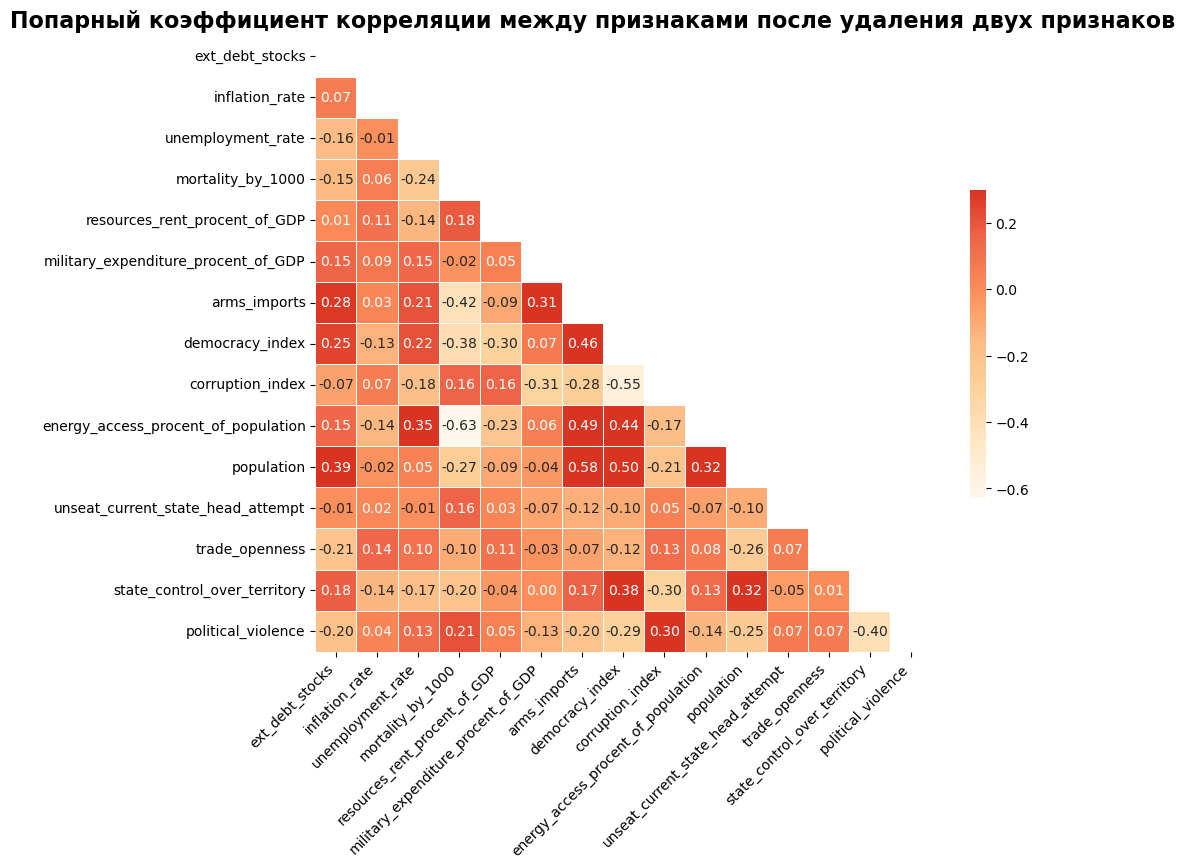

In [94]:
corr = data.copy().drop(columns=['is_conflict']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, cmap='OrRd', vmax=.3, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

title = heatmap.set_title("Попарный коэффициент корреляции между признаками после удаления двух признаков", weight='bold', size=16)
title.set_position([0.45, 1.1])
plt.show()

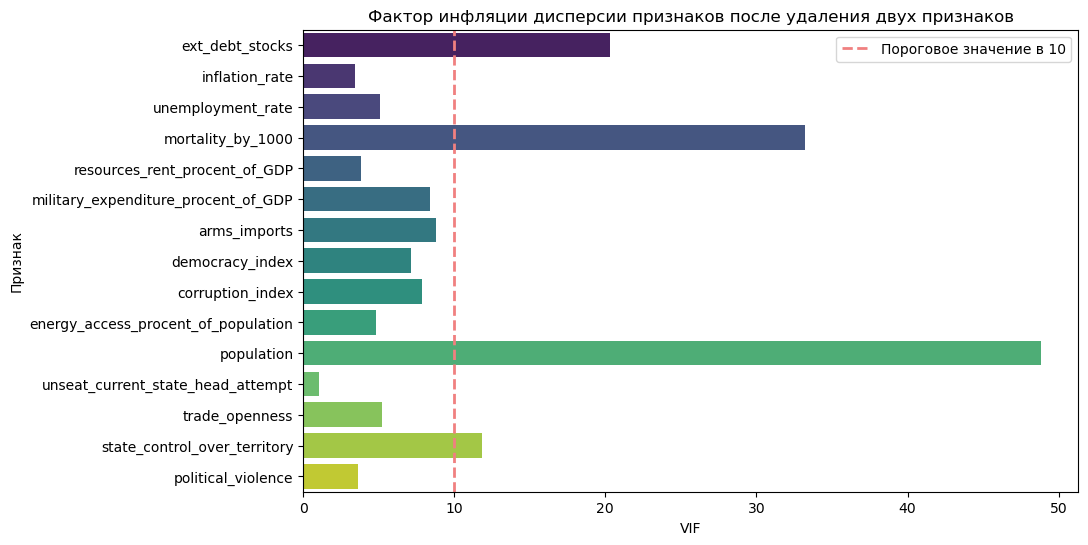

In [95]:
vif_data = pd.DataFrame()
vif_data["feature"] = data.copy().drop(columns=['is_conflict']).columns
vif_data["VIF"] = [variance_inflation_factor(data.copy().drop(columns=['is_conflict']).values, i)
                          for i in range(len(data.copy().drop(columns=['is_conflict']).columns))]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis')
ax.axvline(x=10, color='lightcoral', linestyle='--', linewidth=2, label='Пороговое значение в 10')
plt.title('Фактор инфляции дисперсии признаков после удаления двух признаков')
plt.xlabel('VIF')
plt.ylabel('Признак')
ax.legend()
plt.show()

In [96]:
X = data.drop(columns=['is_conflict'])
y = data.is_conflict

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [98]:
def objective_xgb(trial):
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]), # отношение числа отрицательных классов к положительным - учитываем дизбаланс классов
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.7),
        'seed': 42,
    }
    
    xgb_clf = xgb.XGBClassifier(**xgb_params)
    
    xgb_clf.fit(X_train, y_train,
               verbose=False,
               )
    
    return (roc_auc_score(y_test, (xgb_clf.predict_proba(X_test)[:, 1])))

In [99]:
study_xgb = optuna.create_study(study_name='xgb-seed42',
                                direction='maximize')

[I 2024-02-18 23:25:26,160] A new study created in memory with name: xgb-seed42


In [100]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xgb, n_trials=200,show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [101]:
xgb_best = xgb.XGBClassifier(**study_xgb.best_params)

In [102]:
study_xgb.best_params

{'n_estimators': 2040,
 'learning_rate': 0.025035673149806602,
 'max_depth': 3,
 'min_child_weight': 7,
 'subsample': 0.9850298273019766,
 'colsample_bytree': 0.4677955522856135,
 'gamma': 0.0780814317949612,
 'reg_alpha': 0.0670789110588573,
 'reg_lambda': 0.5660718538345375}

In [103]:
xgb_best.fit(X_train, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4677955522856135, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0780814317949612,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025035673149806602,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2040, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [104]:
y_pred_xgb = xgb_best.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_xgb)

0.828272604588394

In [111]:
def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.7),
        'random_state': 42,
    }
    

    lgbm_clf = lgbm.LGBMClassifier(**params,
                                  early_stopping_rounds=200,
                                  verbose=-1)
                                  
    lgbm_clf.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)])
    
    return (roc_auc_score(y_test, (lgbm_clf.predict_proba(X_test)[:, 1])))

In [112]:
study_lgbm = optuna.create_study(study_name='LGBM-seed42',
                                direction='maximize')

In [113]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm.optimize(objective_lgbm, n_trials=200,show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

In [114]:
lgbm_best = lgbm.LGBMClassifier(**study_lgbm.best_params)

In [115]:
lgbm_best.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 692, number of negative: 66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2930
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.912929 -> initscore=2.349931
[LightGBM] [Info] Start training from score 2.349931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(colsample_bytree=0.858705710032444,
               learning_rate=0.07027573756881285,
               min_child_weight=0.49795211807154194, n_estimators=2793,
               num_leaves=87, reg_alpha=0.44238360644730385,
               reg_lambda=0.42952875048624717)

In [116]:
y_pred_lgbm = lgbm_best.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_lgbm)

0.8246738641475484

In [117]:
y_pred = (y_pred_lgbm + y_pred_xgb) * 0.5

In [118]:
roc_auc_score(y_test, y_pred)

0.8302968960863697

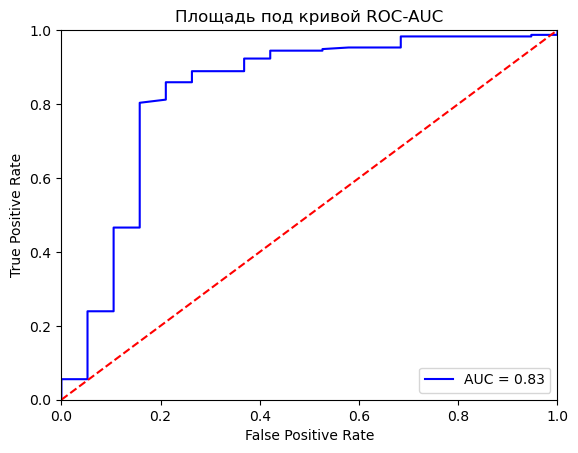

In [119]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Площадь под кривой ROC-AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Определение важности каждого признака. Поскольку 2 модели бустинга мы блендили, то аналогичным образом будем "блендить" и важности признаков в каждой из двух или, другими словами, усреднять "значение важности" по двум моделям.
Выбранные две модели градиентного бустинга имеют разные алгоритмы нахождения важности признаков. Нормализуем каждый столбец.

In [120]:
# Важности признаков для XGBoost
xgb_feature_importance = xgb_best.feature_importances_
# Важности признаков для LightGBM
lgbm_feature_importance = lgbm_best.feature_importances_

# Создадим датафрейм для удобства отображения
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost': xgb_feature_importance,
    'LightGBM': lgbm_feature_importance,
})

def normalize_feature_importance(data):
    data = data.copy()
    
    for col in data.columns:
        if col in ['LightGBM', 'CatBoost']:
            data[col] = data[col] / np.sum(data[col])
                    
    return data

feature_importance = normalize_feature_importance(feature_importance)

# Средние значения важности признаков
feature_importance['average'] = np.mean([feature_importance['XGBoost'],
                                        feature_importance['LightGBM'],], axis=0)

In [121]:
# Сортировка по средней важности
feature_importance = feature_importance.sort_values(by='average', ascending=False)

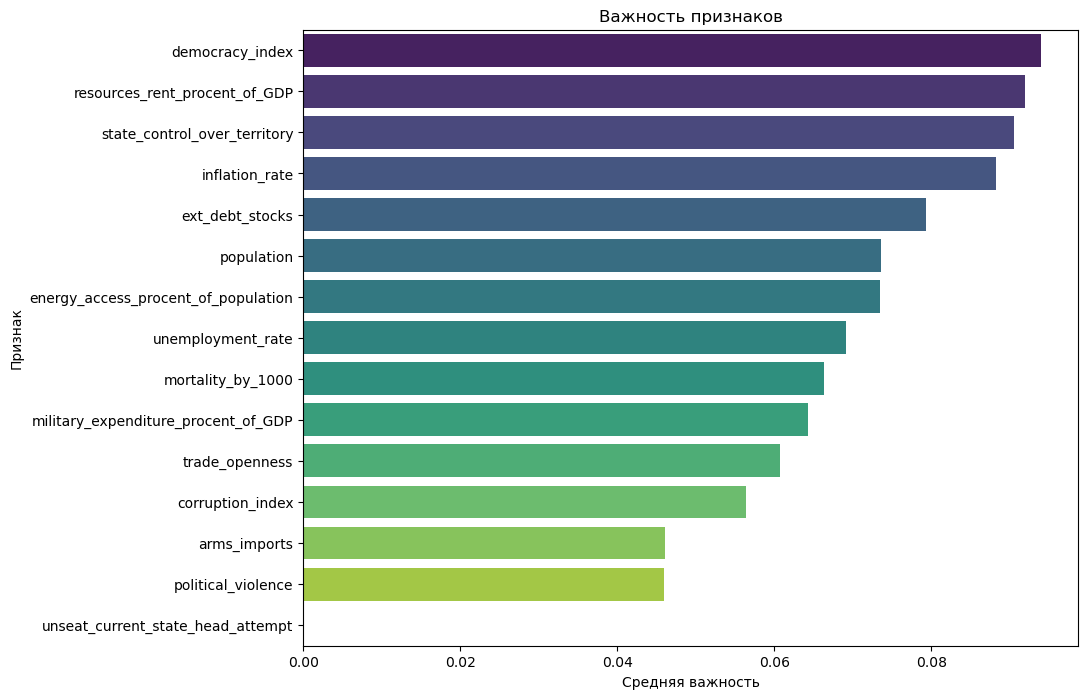

In [123]:
# Отрисовка графика
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='average', y='Feature', palette='viridis')
plt.title('Важность признаков')
plt.xlabel('Средняя важность')
plt.ylabel('Признак')
plt.show()

В топ-5 важных признаков видим сразу признаки из двух групп - военно-политических и экономических:  
1) Демократичность правящей власти (democracy_index) - военно-политический фактор
2) Государственный контроль над территорией страны (state_control_over_territory) - военно-политический фактор
3) Природная рента (resources_rent_procent_of_GDP) - экономический фактор
4) Инфляция (inflation_rate) - экономический фактор

Таким образом, комбинация именно этих факторов играет ключевую роль в предсказании шансов возникновения социальной напряженности внутри страны в определенный год.